## Tutorial: Build a simple LLM application with chat models and prompt templates

In [ ]:
pip install langchain

In [ ]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [ ]:
pip install -qU "langchain[openai]"

In [ ]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

model = init_chat_model("gpt-4o-mini", model_provider="openai")

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    SystemMessage("Translate the following from English into Hebrew"),
    HumanMessage("Hi!"),
]

model.invoke(messages)

In [ ]:
for token in model.stream(messages):
    print(token.content, end="|")

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

system_template = "Translate the following from English into {language}"

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)

In [ ]:
prompt = prompt_template.invoke({"language": "Icelandic", "text": "I am hungry"})

prompt

In [ ]:
prompt.to_messages()

In [ ]:
response = model.invoke(prompt)
print(response.content)

## Tutorial: Build a semantic search engine

In [ ]:
pip install langchain-community pypdf

In [ ]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [ ]:
from langchain_core.documents import Document

documents = [
    Document(
        page_content="Dogs are great companions, known for their loyalty and friendliness.",
        metadata={"source": "mammal-pets-doc"},
    ),
    Document(
        page_content="Cats are independent pets that often enjoy their own space.",
        metadata={"source": "mammal-pets-doc"},
    ),
]

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

file_path = "/Users/petec/Downloads/nke-10k-2023.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()

print(len(docs))

In [ ]:
print(f"{docs[0].page_content[:200]}\n")
print(docs[0].metadata)

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

len(all_splits)

In [ ]:
pip install -qU langchain-openai

In [ ]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [ ]:
vector_1 = embeddings.embed_query(all_splits[0].page_content)
vector_2 = embeddings.embed_query(all_splits[1].page_content)

assert len(vector_1) == len(vector_2)
print(f"Generated vectors of length {len(vector_1)}\n")
print(vector_1[:10])

In [ ]:
pip install -qU langchain-core

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [ ]:
ids = vector_store.add_documents(documents=all_splits)

In [ ]:
results = vector_store.similarity_search(
    "How many distribution centers does Nike have in the US?"
)

print(results[0])

In [ ]:
results = await vector_store.asimilarity_search("When was Nike incorporated?")

print(results[0])

In [ ]:
# Note that providers implement different scores; the score here
# is a distance metric that varies inversely with similarity.

results = vector_store.similarity_search_with_score("What was Nike's revenue in 2023?")
doc, score = results[0]
print(f"Score: {score}\n")
print(doc)

In [ ]:
embedding = embeddings.embed_query("How were Nike's margins impacted in 2023?")

results = vector_store.similarity_search_by_vector(embedding)
print(results[0])

In [ ]:
from typing import List

from langchain_core.documents import Document
from langchain_core.runnables import chain

@chain
def retriever(query: str) -> List[Document]:
    return vector_store.similarity_search(query, k=1)

retriever.batch(
    [
        "How many distribution centers does Nike have in the US?",
        "When was Nike incorporated?",
    ],
)

In [ ]:
retriever = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 1},
)

retriever.batch(
    [
        "How many distribution centers does Nike have in the US?",
        "When was Nike incorporated?",
    ],
)

## Tutorial: Build a Retrieval Augmented Generation (RAG) App: Part 1

In [ ]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

In [ ]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [ ]:
pip install -qU "langchain[openai]"

In [ ]:
# Select the chat model
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [ ]:
# Select the embeddings model
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [ ]:
%pip install -qU langchain-core

In [ ]:
# Select the vector store
from langchain_core.vectorstores import InMemoryVectorStore
vector_store = InMemoryVectorStore(embeddings)

In [ ]:
# App: create a simple indexing pipeline and RAG chain
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Index chunks
_ = vector_store.add_documents(documents=all_splits)

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# Define application steps
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [ ]:
response = graph.invoke({"question": "What is Task Decomposition?"})
#print(f'Context: {response["context"]}\n\n')
print(response["answer"])

In [ ]:
# Stream steps
for step in graph.stream({"question": "What is Task Decomposition?"}, stream_mode="updates"):
    print(f"{step}\n\n----------------\n")

In [ ]:
# Stream tokens
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

In [ ]:
# Async invocation
response = await graph.ainvoke({"question": "What is Task Decomposition?"})
print(response["answer"])

In [ ]:
# Add Query Analysis
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

In [ ]:
# Update Vector Store
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [ ]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [ ]:
# Full Code with Search Query added
from typing import Literal
import bs4

from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import Annotated, List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# Update metadata (illustration purposes)
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


# Index chunks
vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)


# Define schema for search
class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

# Define prompt for question-answering
prompt = hub.pull("rlm/rag-prompt")


# Define state for application
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
for step in graph.stream(
    {"question": "What does the end of the post say about Task Decomposition?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

## Tutorial: Build a Retrieval Augmented Generation (RAG) App: Part 2

In [ ]:
pip install -qU "langchain[openai]"

In [ ]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [ ]:
pip install -qU langchain-openai

In [ ]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [ ]:
pip install -qU langchain-core

In [ ]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [ ]:
%%capture --no-stderr
%pip install --upgrade --quiet langgraph langchain-community beautifulsoup4

In [ ]:
os.environ["LANGSMITH_TRACING"] = "true"
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

In [ ]:
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from typing_extensions import List, TypedDict

# Load and chunk contents of the blog
loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

In [ ]:
# Index chunks
_ = vector_store.add_documents(documents=all_splits)

In [ ]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [ ]:
from langchain_core.tools import tool

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [ ]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode

# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}

# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])

# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [ ]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

In [ ]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [ ]:
input_message = "What is Task Decomposition?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

In [ ]:
input_message = "Can you look up some common ways of doing it?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from typing import Annotated
from typing_extensions import TypedDict
from operator import add

class State(TypedDict):
    foo: str
    bar: Annotated[list[str], add]

def node_a(state: State):
    return {"foo": "a", "bar": ["a"]}

def node_b(state: State):
    return {"foo": "b", "bar": ["b"]}


workflow = StateGraph(State)
workflow.add_node(node_a)
workflow.add_node(node_b)
workflow.add_edge(START, "node_a")
workflow.add_edge("node_a", "node_b")
workflow.add_edge("node_b", END)

checkpointer = MemorySaver()
graph = workflow.compile(checkpointer=checkpointer)

config = {"configurable": {"thread_id": "1"}}
graph.invoke({"foo": ""}, config)

In [ ]:
graph.get_state(config)

In [ ]:
list(graph.get_state_history(config))

### Agents

In [94]:
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

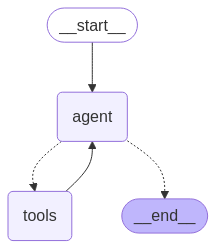

In [95]:
display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [96]:
config = {"configurable": {"thread_id": "def234"}}

input_message = (
    "What is the standard method for Task Decomposition?\n\n"
    "Once you get the answer, look up common extensions of that method."
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the standard method for Task Decomposition?

Once you get the answer, look up common extensions of that method.
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_CFCrxginQWqAKRFMFT5HWfEe)
 Call ID: call_CFCrxginQWqAKRFMFT5HWfEe
  Args:
    query: standard method for Task Decomposition
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}
Content: Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The search process can be BFS (breadth-first search) or DFS (depth-first search) with each state evaluated by a classifier (via a prompt) or majori

## Tutorial: LangSmith

In [ ]:
pip install -U langsmith openai

In [ ]:
import os

os.environ['LANGSMITH_TRACING'] = "true"
os.environ['LANGSMITH_API_KEY'] = ""
# The example uses OpenAI, but it's not necessary if your code uses another LLM provider
os.environ['OPENAI_API_KEY'] = ""

In [ ]:
from openai import OpenAI
from langsmith import traceable
from langsmith.wrappers import wrap_openai

openai_client = wrap_openai(OpenAI())

# This is the retriever we will use in RAG
# This is mocked out, but it could be anything we want
def retriever(query: str):
    results = [
        "Harrison worked at Kensho",
        "Los Angeles is in Southern California"
    ]
    return results

# This is the end-to-end RAG chain.
# It does a retrieval step then calls OpenAI
@traceable
def rag(question):
    docs = retriever(question)
    system_message = """Answer the users question using only the provided information below:
    
    {docs}""".format(docs="\n".join(docs))
    
    return openai_client.chat.completions.create(
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": question},
        ],
        model="gpt-4o-mini",
    )

In [ ]:
rag("where is Los Angeles ?")